# Jupyter Notebooks for the book:
#Semiconductor Integrated Optics for Switching Light 2nd Edition

## Semiconductor Waveguide design

Notebook for Chapter 1:

Started Jan 2021

Prof. Charlie Ironside, Department of Physics and Astronomy, Curtin University, Bentley Campus, Western Australia 6102.

email: Charlie.Ironside@curtin.edu.au

web page address:http://oasisapps.curtin.edu.au/staff/profile/view/Charlie.Ironside

This notebook can be used to design semiconductor waveguides using colab - it uses the emopt Finite-Difference Time-Domain (FDTD) package from:-

https://github.com/anstmichaels/emopt

Documentation

https://emopt.readthedocs.io/en/latest/tutorial_2D_waveguide_sim.html

many thanks to the author of emopt Andy Michaels for adapting his package to run on Colab

The first cell builds the packages for Colab that are required to run the subsequent code - PLEASE NOTE it will take around **5 minutes load the complete set of packages required** - have a coffee and ignore error messages at the end of the loading packages process.

So this first cell must be run before subsequent code will work but then it will OK for the rest of your colab session


In [2]:
# Install ALL system dependencies (including petsc, slepc, boost, and eigen)
!apt-get -qq install -y build-essential gfortran openmpi-bin libopenmpi-dev python python-dev python-pip git python-tk libpetsc-complex-3.7 libpetsc-complex-3.7-dev libslepc-complex-3.7 libslepc-complex-3.7-dev libboost-all-dev libeigen3-dev 

# Install some of the optional python requirements
!pip install requests matplotlib numpy scipy mpi4py h5py

# Clone the emopt repo
!git clone https://github.com/anstmichaels/emopt.git

# Install emopt
!cd emopt && git checkout colab && PETSC_DIR='/usr/lib/petsc' PETSC_ARCH='' SLEPC_DIR='/usr/lib/slepc' python3 setup.py install

# Restart the runtime -- necessary to make the newly installed modules visible to the interpreter
exit()

Extracting templates from packages: 100%
Selecting previously unselected package binfmt-support.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../00-binfmt-support_2.1.8-2_amd64.deb ...
Unpacking binfmt-support (2.1.8-2) ...
Selecting previously unselected package ksh.
Preparing to unpack .../01-ksh_93u+20120801-3.1ubuntu1_amd64.deb ...
Unpacking ksh (93u+20120801-3.1ubuntu1) ...
Selecting previously unselected package libsuitesparseconfig5:amd64.
Preparing to unpack .../02-libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../03-libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libblas3:amd64.
Preparing to unpack .../04-libblas3_3.7.1-4ubuntu1_amd64.deb ...
Unpacking libblas3:amd64 (3.7.1-4ubuntu1) ...
Selecting previously unselected package libblas-

The next cell is a database of the optical properties for a large range of materials the materials -it's the file nk.py and it's taken from :-

https://github.com/lbolla/EMpy

It has the refractive index for lots of materials - here we just really need the refractive index of  $Al_xGa_{1-x}As$  as a function x and wavelength

In [1]:
'''
Database file of functions to return refractive indices of various materials.
This file, nk.py should be in same dir as script, or in the python path somewhere. 

All wavelengths are in MICRONS

After importing,
    call `help( nk )` to see usage info.
    call `dir( nk )` to list defined materials
    call `help( nk.Si )` to see info on specific material model



Materials may be called from another script like so:

    import nk
    # Return the refractive index of SiO2 at the given wavelength(s):
    >>> nk.SiO(1.550)       
    : 1.448333
    
You can pass/return multiple wavelengths/indices. They must in a numpy.array (not [list]), as so:
    >>> nk.SiO(  numpy.array([1.550, 1.551, 1.552])  )       
    : array([ 1.4483336 ,  1.44832036,  1.44830712])

-- OR --
    
    core_material = nk.SiN   # Despite appearances, these are functions, not variables!
    core_material( 1.550 )      # will give index at that wavelength
    
    # Return the refractive index for the Alloy Al(0.92)Ga(0.08)As @ 1.550 micron wavelength:
    >>> nk.AlGaAs(0.92, 1.550)   
    : 2.93059
    
    
Complex Refractive indices, in the form (n + i*k), can be requested from certain materials via the `k=True` argument, as so:
    >>> nk.GaSb( 0.632 , k=True)
    : (4.9285209602676332-0.69616573380335467j)


Materials may be defined in this file like so:
    >>> cauchy = lambda p ,x: p[0] + p[1]/x**2 + p[2]/x**4      
  where cauchy is a defined lambda (in-line) fitting function, and p can be passed as a list/tuple of 3 values to set the constants in the equations.
  For SiO2 with the Cauchy fitting params of A=1.4764, B=0.0229, C=-0.012346 (for wavelength in microns):
    >>> SiO2 = lambda x: cauchy([ 1.4764 , 0.02299 , -0.012346 ], x)     # note x is still a passed variable.
    >>> SiO2( 1.550 )    # in microns! (as defined by fitting params, above)
    : 1.4764000095691965
    
See the GaAs_interp & GaSb_interp functions for examples of how to interpolate directly from raw tabulated data, which can be found online for various materials at websites like:
    http://www.filmetrics.com/refractive-index-database
    https://refractiveindex.info
    

Originally written by Dustin Kleckner, U.C. Santa Barbara, 2008
Demis D. John:  2009 added some Cauchy fits for SiO2, Ta2O5, SiN
                2012: Added some semiconductor alloys, such as GaAs, AlGaAs etc.
                2014: Migrated some lambda functions over to full def() functions, so that they have docstrings & wavelength range warnings.
                2017: Added complex index (absorption) values to some functions via argument `k=True`.  Added interpolated data functions for GaAs & GaSb.


######################################################
'''



###########################
''' Import some modules '''
###########################
import numpy as np      # array math
import warnings # warn user if invalid parameter, but continue program
import numpy.polynomial.polynomial as poly  # polynomial fitting/reconstruction




##############################################
''' 		Refractive Index models 		'''
##############################################

lorentzian = lambda p, x:  p[0] + p[1] * x +  p[2] * .25 * p[3]**2 / ((x - p[4])**2 + .25 * p[3]**2)
lorentzian.__doc__ = ''' A Lorentzian on a linear background -- provides a much better fit than polynomial!'''

cauchy = lambda p, x:   p[0] + p[1]/x**2 + p[2]/x**4
cauchy.__doc__ = ''' 3-parameter lossless Cauchy fit, as used on the J.A.Woolam WVase Ellipsometer:'''


cauchy5 = lambda p, x:  p[0] + p[1]/x**2 + p[2]/x**4 + p[3]/x**6 + p[4]/x**8
cauchy5.__doc__ = ''' 5-parameter Cauchy fit  '''


cauchy2offset = lambda p, x: p[0] + p[1]/x**2 + p[2]
cauchy2offset.__doc__ = \
''' LiONiX (SiN): Cauchy model with birefringent offset
   A + B/lambda^2 + C   '''


sellmeier = lambda p, x:    np.sqrt(   p[0] + ( (p[1] * x**2)/(x**2 - p[2]**2) )  - p[3]* x**2   )
sellmeier.__doc__ = \
''' Sellmeier according to [1]
    n^2 = offset + ((a*lambda^2)/(lambda^2 - b^2)) - c*lambda^2
    where   p[0], p[1], p[2], p[3] = offset, a, b, c   respectively '''


def sellmeier1(p,x):
    '''Sellmeier according to [2]: Mondry...Coldren: AlInGaAs on InP
    n^2 = a + ( (b*lambda^2)/(lambda^2 - c^2) )
        where   p[0], p[1], p[2] = a, b, c   respectively
        
        Re-using `sellmeier()`, with C=0
    '''
    return  sellmeier(  (p[0], p[1], p[2], 0) , x)


sellmeier5 = lambda p,x: np.sqrt(   p[0] + ( p[1] * x**2 / (x**2 - p[2]**2) ) + ( p[3] * x**2 / (x**2 - p[4]**2) )   )
sellmeier5.__doc__ =    \
''' Sellmeier with 5 params - 
#### CHECK THIS - maybe not good model - curvature doesn't look right   
'''


sellmeier7_1 = lambda p,x: np.sqrt(  1 + p[0] + ( p[1] * x**2 / (x**2 - p[2]**2) ) + ( p[3] * x**2 / (x**2 - p[4]**2) ) + ( p[5] * x**2 / (x**2 - p[6]**2) )  )
sellmeier7_1.__doc__ = """ Sellmeier with 7 params and '1+...' """



sellmeier8_1 = lambda p,x: np.sqrt(  1 + ( p[0] * x**2 / (x**2 - p[1]**2) ) + ( p[2] * x**2 / (x**2 - p[3]**2) ) + ( p[4] * x**2 / (x**2 - p[5]**2) ) + ( p[6] * x**2 / (x**2 - p[7]**2) )  )
sellmeier8_1.__doc__ = """Sellmeier with 8 params and '1+...' """



fillfraction = lambda base, fill: lambda x: (1.0 - fill) + fill * base(x)
fillfraction.__doc__ = '''Fill fraction, to reduce index of refraction'''


##############################################
## 			Other Utility Functions			##
def wave(t, n):
    '''
    return number of wavelengths (wavelength fraction), given 
    t: thickness (um) & 
    n: Refractive Index
    For example: 
        Convert 10nm of InP to the wavelength-equivalent @ 1.410um:
        >>> wave( 0.010, n.InP(1.410) )
    '''
    return  t/(wl / n)  

def thick(wave, n):
    '''
    return thickness given 
    wave: wave-fraction
    n: Refractive index
    For example: 
        Convert 1/2-wave of InP to the thickness-equivalent @ 1.410um:
        >>> wave( 0.5, n.InP(1.410) )
    '''
    return  wave * (wl/n)    



##################################################
##                    Films:                    ##
##################################################

##################################################
##              Metals & Alloys                 ##
##################################################

def Si( wl ):
    '''
    Calculate refractive index of Silicon at specified wavelength.    
    Valid from 0.400-1.200um 
    
    Silicon, from luxpop.com
    Fit for 400-1200.  RMS error: 9E-3
    Error is more than others, maxing at around ~0.02
    This is due to proximity of bandgap!
    -- Dustin Kleckner, UCSB, ~2008
    
    Args:
        wl: wavelength in microns (float)
    Returns:
        Refractive index (float)
    Raises:
        Warning for wavelength out of model range
    
    '''
    check_wl(wl, 0.400, 1.200, 'Si')
    return lorentzian([3.72152, -1.83137E-4, 2.33148E+5, 8.73460E-1, 2.50691E2], wl)
#end def(Si)


def AlAs( wl ):
    '''
    Calculate refractive index of AlAs at specified wavelength.    
    Valid from 0.56~2.2um 
    
    http://refractiveindex.info/legacy/?group=CRYSTALS&material=AlAs&option=HO&wavelength=1.050
    
    Handbook of Optics, 2nd edition, Vol. 2. McGraw-Hill 1994
    
    Args:
        wl: wavelength in microns (float)
    Returns:
        Refractive index (float)
    Raises:
        Warning for wavelength out of model range
    
    '''
    check_wl(wl, 0.560, 2.300, 'AlAs')
    return sellmeier5( (2.0792, 6.0840, 0.2822, 1.900, 27.62), wl )


def AlAs_interp( wl, k=False ):
    ''' 
    Calculate refractive index of GaAs at specified wavelength with optional loss (k) returned as complex index, interpolated from tabulated data.    
    Valid from 206~2480nm
    
            
    Tabulated data from:
    http://www.filmetrics.com/refractive-index-database/AlAs/Aluminium-Arsenide
    M. Garriga, P. Lautenschlager, M. Cardona, and K. Ploog, Solid State Commun. 61, 157 (1987) (UV data) and S. Adachi, J. Appl. Phys. 58, R1 (1985) (Vis and NIR data)
    
    Uses Numpy interpolation to return values - will raise error if requested wavelength is outside range.
    
    Args:
        wl: wavelength in microns (float)
        k : {True | False}, optional
            False by default. If True, returns complex refractive indices.
    Returns:
        Refractive index (float), complex if k=True
    Raises:
        Warning for wavelength out of model range
    
    '''
    wl = np.atleast_1d(wl) # ensure arg is array
    
    # raw data:
    wls = 1e-3 * np.array([  \
         221.                ,   221.4300000000000068,
         223.4199999999999875,   225.4499999999999886,
         227.5200000000000102,   229.6299999999999955,
         231.7800000000000011,   233.960000000000008 ,
         236.1899999999999977,   238.460000000000008 ,
         240.7800000000000011,   243.1399999999999864,
         245.539999999999992 ,   248.                ,
         250.5099999999999909,   253.0600000000000023,
         255.6699999999999875,   258.3299999999999841,
         261.0500000000000114,   263.8299999999999841,
         266.6700000000000159,   269.5699999999999932,
         272.5299999999999727,   275.5600000000000023,
         278.6499999999999773,   281.8199999999999932,
         285.0600000000000023,   288.3700000000000045,
         291.7599999999999909,   295.2400000000000091,
         298.8000000000000114,   302.4399999999999977,
         306.1700000000000159,   310.                ,
         313.9200000000000159,   317.9499999999999886,
         322.0799999999999841,   326.3199999999999932,
         330.6700000000000159,   335.1399999999999864,
         339.7300000000000182,   344.4399999999999977,
         349.3000000000000114,   354.2900000000000205,
         359.4200000000000159,   364.7099999999999795,
         370.1499999999999773,   375.7599999999999909,
         381.5400000000000205,   387.5               ,
         393.6499999999999773,   400.                ,
         406.5600000000000023,   413.3299999999999841,
         420.339999999999975 ,   427.589999999999975 ,
         435.089999999999975 ,   442.8600000000000136,
         450.910000000000025 ,   459.2599999999999909,
         467.9200000000000159,   476.9200000000000159,
         486.2699999999999818,   496.                ,
         506.1200000000000045,   516.6699999999999591,
         527.6599999999999682,   539.1299999999999955,
         551.1100000000000136,   563.6399999999999864,
         576.7400000000000091,   590.4800000000000182,
         604.8799999999999955,   620.                ,
         635.8999999999999773,   652.6299999999999955,
         670.2699999999999818,   688.8899999999999864,
         708.57000000000005  ,   729.4099999999999682,
         751.5199999999999818,   775.                ,
         800.                ,   826.6699999999999591,
         855.1699999999999591,   885.7100000000000364,
         918.5199999999999818,   953.8500000000000227,
         992.                ,  1033.3299999999999272,
        1078.2599999999999909,  1127.2699999999999818,
        1180.9500000000000455,  1240.                ,
        1305.2599999999999909,  1377.7799999999999727,
        1458.8199999999999363,  1550.                ,
        1653.3299999999999272,  1771.4300000000000637,
        1907.6900000000000546,  2066.6700000000000728,
        2254.5500000000001819,  2480.                ])
    
    check_wl(wl, np.min(wls), np.max(wls), 'AlAs_interp')
    
    ns = np.array([ \
        1.3209299999999999,  1.3600000000000001,  1.3706            ,
        1.3600000000000001,  1.3493999999999999,  1.3600000000000001,
        1.4299999999999999,  1.53              ,  1.6363000000000001,
        1.77              ,  1.96              ,  2.1600000000000001,
        2.3169            ,  2.48              ,  2.6850000000000001,
        2.9199999999999999,  3.1974999999999998,  3.48              ,
        3.7387999999999999,  3.96              ,  4.1224999999999996,
        4.2199999999999998,  4.2249999999999996,  4.1799999999999997,
        4.1093999999999999,  4.04              ,  4.0099999999999998,
        4.0099999999999998,  4.0355999999999996,  4.1100000000000003,
        4.2680999999999996,  4.4699999999999998,  4.6905999999999999,
        4.9199999999999999,  5.1605999999999996,  5.3499999999999996,
        5.4218999999999999,  5.3899999999999997,  5.2093999999999996,
        4.9900000000000002,  4.8449999999999998,  4.7199999999999998,
        4.5944000000000003,  4.4800000000000004,  4.3856000000000002,
        4.2999999999999998,  4.2163000000000004,  4.1299999999999999,
        4.0293999999999999,  3.9300000000000002,  3.8450000000000002,
        3.77              ,  3.7052            ,  3.6493000000000002,
        3.6013000000000002,  3.5602999999999998,  3.5253000000000001,
        3.4954999999999998,  3.4699            ,  3.4474999999999998,
        3.4274            ,  3.4087999999999998,  3.3904999999999998,
        3.3717999999999999,  3.3515999999999999,  3.3290000000000002,
        3.3012999999999999,  3.2730000000000001,  3.2481            ,
        3.2250000000000001,  3.2033999999999998,  3.1829999999999998,
        3.1634000000000002,  3.145             ,  3.1280000000000001,
        3.1120000000000001,  3.0966            ,  3.0819999999999999,
        3.0686            ,  3.056             ,  3.0438000000000001,
        3.032             ,  3.0207999999999999,  3.0099999999999998,
        2.9996999999999998,  2.9900000000000002,  2.9813000000000001,
        2.9729999999999999,  2.9647999999999999,  2.9569999999999999,
        2.9498000000000002,  2.9430000000000001,  2.9363000000000001,
        2.9300000000000002,  2.9243000000000001,  2.919             ,
        2.9138000000000002,  2.9089999999999998,  2.9047999999999998,
        2.9009999999999998,  2.8974000000000002,  2.8940000000000001,
        2.8908999999999998,  2.8879999999999999     ])
    
    ks = np.array([  \
         2.4303080000000001e+00,   2.7500000000000000e+00,
         2.8062999999999998e+00,   2.8900000000000001e+00,
         2.9963000000000002e+00,   3.1200000000000001e+00,
         3.2587999999999999e+00,   3.3999999999999999e+00,
         3.5293999999999999e+00,   3.6499999999999999e+00,
         3.7650000000000001e+00,   3.8599999999999999e+00,
         3.9125000000000001e+00,   3.9500000000000002e+00,
         4.0019000000000000e+00,   4.0400000000000000e+00,
         4.0556000000000001e+00,   4.0199999999999996e+00,
         3.8969000000000000e+00,   3.7000000000000002e+00,
         3.4037999999999999e+00,   3.0899999999999999e+00,
         2.8288000000000002e+00,   2.6299999999999999e+00,
         2.5463000000000000e+00,   2.5200000000000000e+00,
         2.5063000000000000e+00,   2.5200000000000000e+00,
         2.5718999999999999e+00,   2.6299999999999999e+00,
         2.6738000000000000e+00,   2.6800000000000002e+00,
         2.6093999999999999e+00,   2.4900000000000002e+00,
         2.3613000000000000e+00,   2.1499999999999999e+00,
         1.7380000000000000e+00,   1.3000000000000000e+00,
         9.8740000000000006e-01,   7.5200000000000000e-01,
         6.1280000000000001e-01,   5.1900000000000002e-01,
         4.1830000000000001e-01,   3.3400000000000002e-01,
         2.7779999999999999e-01,   2.3300000000000001e-01,
         1.8120000000000000e-01,   1.3900000000000001e-01,
         1.2130000000000001e-01,   1.1500000000000000e-01,
         1.1320000000000000e-01,   1.1300000000000000e-01,
         1.1070000000000001e-01,   1.0240000000000000e-01,
         8.0399999999999999e-02,   5.2999999999999999e-02,
         2.3400000000000001e-02,   0.0000000000000000e+00,
         3.3000000000000000e-03,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00   ])
    
    ns = np.interp( wl, wls, ns )
    ks = np.interp( wl, wls, ks )
    if k:
        return (ns - 1j*ks)
    else:
        return ns
#end def(AlAs_interp)




def GaAs( wl ):
    ''' 
    Calculate refractive index of GaAs at specified wavelength for mid-Infra-Red        
    Valid from 1.4~11um
    
    http://refractiveindex.info/legacy/?group=CRYSTALS&material=GaAs
        
    Handbook of optics, 3rd ed., Vol. 4, mcgraw hill 2009
    
    Args:
        wl: wavelength in microns (float)
    Returns:
        Refractive index (float)
    Raises:
        Warning for wavelength out of model range
    
    '''
    check_wl(wl, 1.400, 12.0, 'GaAs_mIR')
    return sellmeier5( (3.5, 7.4969, 0.4082, 1.9347, 37.17), wl )
#end def(GaAs_mIR)


def GaAs_mIR( wl ):
    ''' 
    Calculate refractive index of GaAs at specified wavelength.    
    Valid from 0.97~17 um
    
    http://refractiveindex.info/?shelf=main&book=GaAs&page=Skauli
    
    T. Skauli, P. S. Kuo, K. L. Vodopyanov, T. J. Pinguet, O. Levi, L. A. Eyres, J. S. Harris, M. M. Fejer, B. Gerard, L. Becouarn, and E. Lallier. Improved dispersion relations for GaAs and applications to nonlinear optics, J. Appl. Phys., 94, 6447-6455 (2003)
    
    Args:
        wl: wavelength in microns (float)
    Returns:
        Refractive index (float)
    Raises:
        Warning for wavelength out of model range
    
    '''
    check_wl(wl, 0.970, 17.50, 'GaAs')
    return sellmeier7_1( (4.372514, 5.466742, 0.4431307, 0.02429960, 0.8746453, 1.957522, 36.9166), wl )
#end def(GaAs)
# Should conditionally switch to mIR model depending on passed WL...


def GaAs_interp( wl, k=False ):
    ''' 
    Calculate refractive index of GaAs at specified wavelength with optional loss (k) returned as complex index, interpolated from tabulated data.    
    Valid from 206~2066nm
    
            
    Tabulated data from:
    http://www.filmetrics.com/refractive-index-database/GaAs/Gallium-Arsenide
    Reference: J. B. Theeten, D. E. Aspnes, and R. P. H. Chang, J. Appl. Phys. 49, 6097 (1978)
    
    Uses Numpy interpolation to return values - will raise error if requested wavelength is outside range.
    
    Args:
        wl: wavelength in microns (float)
        k : {True | False}, optional
            False by default. If True, returns complex refractive indices.
    Returns:
        Refractive index (float), complex if k=True
    Raises:
        Warning for wavelength out of model range
    
    '''
    wl = np.atleast_1d(wl) # ensure arg is array
    
    # raw data:
    wls = 1e-3 * np.array([   \
         206.6299999999999955,   210.1399999999999864,
         213.7599999999999909,   217.5099999999999909,
         221.3899999999999864,   225.4199999999999875,
         229.5900000000000034,   233.9199999999999875,
         238.4199999999999875,   243.0999999999999943,
         247.960000000000008 ,   253.0200000000000102,
         258.2900000000000205,   263.7900000000000205,
         269.5199999999999818,   275.5099999999999909,
         281.7699999999999818,   288.3299999999999841,
         295.1899999999999977,   302.3899999999999864,
         309.9499999999999886,   317.8999999999999773,
         326.2599999999999909,   335.0799999999999841,
         344.3899999999999864,   354.2300000000000182,
         364.6499999999999773,   375.6999999999999886,
         387.4399999999999977,   399.9399999999999977,
         413.2699999999999818,   427.5199999999999818,
         442.7900000000000205,   459.1899999999999977,
         476.8500000000000227,   495.9200000000000159,
         516.5800000000000409,   539.0399999999999636,
         563.5499999999999545,   590.3799999999999955,
         619.8999999999999773,   652.5299999999999727,
         688.7799999999999727,   729.2899999999999636,
         774.8700000000000045,   826.5299999999999727,
         885.57000000000005  ,   953.6900000000000546,
        1033.1700000000000728,  1127.0899999999999181,
        1239.7999999999999545,  1377.5599999999999454,
        1549.75              ,  1771.1400000000001   ,
        2066.3299999999999272   \
        ])
    
    check_wl(wl, np.min(wls), np.max(wls), 'GaAs_interp')
    
    ns = np.array([    \
        1.264             ,  1.288             ,  1.3109999999999999,
        1.325             ,  1.349             ,  1.383             ,
        1.4299999999999999,  1.4990000000000001,  1.599             ,
        1.802             ,  2.2730000000000001,  2.8900000000000001,
        3.3420000000000001,  3.5979999999999999,  3.7690000000000001,
        3.9129999999999998,  4.0149999999999997,  3.9390000000000001,
        3.8100000000000001,  3.6920000000000002,  3.601             ,
        3.5379999999999998,  3.5009999999999999,  3.4849999999999999,
        3.4950000000000001,  3.5310000000000001,  3.5960000000000001,
        3.7090000000000001,  3.9380000000000002,  4.3730000000000002,
        4.5090000000000003,  5.0519999999999996,  4.9589999999999996,
        4.694             ,  4.492             ,  4.3330000000000002,
        4.2050000000000001,  4.0999999999999996,  4.0129999999999999,
        3.9399999999999999,  3.8780000000000001,  3.8260000000000001,
        3.7850000000000001,  3.742             ,  3.7000000000000002,
        3.6659999999999999,  3.6139999999999999,  3.5388000000000002,
        3.492             ,  3.4546000000000001,  3.4232            ,
        3.3965000000000001,  3.3736999999999999,  3.3542999999999998,
        3.3378000000000001  \
        ])
    
    ks = np.array([    \
         2.4720000000000000e+00,   2.5569999999999999e+00,
         2.6250000000000000e+00,   2.7100000000000000e+00,
         2.8149999999999999e+00,   2.9359999999999999e+00,
         3.0790000000000002e+00,   3.2549999999999999e+00,
         3.4840000000000000e+00,   3.7949999999999999e+00,
         4.0839999999999996e+00,   4.0469999999999997e+00,
         3.7700000000000000e+00,   3.4520000000000000e+00,
         3.1690000000000000e+00,   2.9190000000000000e+00,
         2.5630000000000002e+00,   2.2599999999999998e+00,
         2.0690000000000000e+00,   1.9690000000000001e+00,
         1.9199999999999999e+00,   1.9039999999999999e+00,
         1.9090000000000000e+00,   1.9310000000000000e+00,
         1.9650000000000001e+00,   2.0129999999999999e+00,
         2.0760000000000001e+00,   2.1619999999999999e+00,
         2.2879999999999998e+00,   2.1459999999999999e+00,
         1.9480000000000000e+00,   1.7210000000000001e+00,
         9.9099999999999999e-01,   6.9599999999999995e-01,
         5.3900000000000003e-01,   4.4100000000000000e-01,
         3.7100000000000000e-01,   3.2000000000000001e-01,
         2.7600000000000002e-01,   2.3999999999999999e-01,
         2.1099999999999999e-01,   1.7899999999999999e-01,
         1.5100000000000000e-01,   1.1200000000000000e-01,
         9.0999999999999998e-02,   8.0000000000000002e-02,
         1.6999999999999999e-03,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00,   0.0000000000000000e+00,
         0.0000000000000000e+00 \
         ])
    
    ns = np.interp( wl, wls, ns )
    ks = np.interp( wl, wls, ks )
    if k:
        return (ns - 1j*ks)
    else:
        return ns
#end def(GaAs_interp)



def GaSb_interp( wl, k=False ):
    ''' 
    Calculate refractive index (complex) of GaSb at specified wavelength.
    Valid from from 206.6 nm to 826.6 nm. Interpolation of raw tabulated data.
        
    https://refractiveindex.info/?shelf=main&book=GaSb&page=Aspnes
        
    D. E. Aspnes and A. A. Studna. Dielectric functions and optical parameters of Si, Ge, GaP, GaAs, GaSb, InP, InAs, and InSb from 1.5 to 6.0 eV, Phys. Rev. B, 27, 985-1009 (1983)
    https://doi.org/10.1103/PhysRevB.27.985
    
    
    
    Args:
        wl: wavelength in microns (float)
        k : {True | False}, optional
            False by default. If True, returns complex refractive indices.
    Returns:
        Refractive index (float), complex if k=True
    Raises:
        Warning for wavelength out of model range
    
    '''
    wl = np.atleast_1d(wl) # ensure arg is array
    
    
    # raw data:
    wls = np.array([     \
        0.2066            ,  0.2101            ,  0.2138            ,
        0.2175            ,  0.2214            ,  0.2254            ,
        0.2296            ,  0.2339            ,  0.2384            ,
        0.2431            ,  0.248             ,  0.253             ,
        0.2583            ,  0.2638            ,  0.2695            ,
        0.2755            ,  0.2818            ,  0.2883            ,
        0.2952            ,  0.3024            ,  0.31              ,
        0.3179            ,  0.3263            ,  0.3351            ,
        0.3444            ,  0.3542            ,  0.3647            ,
        0.3757            ,  0.3875            ,  0.3999            ,
        0.4133            ,  0.4275            ,  0.4428            ,
        0.4592            ,  0.4769            ,  0.4959            ,
        0.5165999999999999,  0.5391            ,  0.5636            ,
        0.5904            ,  0.6199            ,  0.6525            ,
        0.6888            ,  0.7292999999999999,  0.7749            ,
        0.8266  \
        ])
    
    check_wl(wl, np.min(wls), np.max(wls), 'GaSb_interp')
    
    ns = np.array([     \
        0.9350000000000001,  0.985             ,  1.022             ,
        1.0620000000000001,  1.127             ,  1.212             ,
        1.2989999999999999,  1.345             ,  1.3560000000000001,
        1.3580000000000001,  1.369             ,  1.387             ,
        1.4079999999999999,  1.444             ,  1.5029999999999999,
        1.5860000000000001,  1.7230000000000001,  1.9890000000000001,
        2.5219999999999998,  3.1000000000000001,  3.4500000000000002,
        3.6200000000000001,  3.7010000000000001,  3.7480000000000002,
        3.774             ,  3.7850000000000001,  3.794             ,
        3.8079999999999998,  3.7999999999999998,  3.766             ,
        3.7320000000000002,  3.7280000000000002,  3.7599999999999998,
        3.8359999999999999,  3.984             ,  4.3120000000000003,
        4.5129999999999999,  4.492             ,  4.5209999999999999,
        4.7050000000000001,  5.2389999999999999,  5.0519999999999996,
        4.8170000000000002,  4.6429999999999998,  4.5069999999999997,
        4.3879999999999999  \
        ])
    
    ks = np.array([     \
        2.4159999999999999,  2.444             ,  2.4790000000000001,
        2.5350000000000001,  2.6019999999999999,  2.645             ,
        2.653             ,  2.6379999999999999,  2.645             ,
        2.6850000000000001,  2.7509999999999999,  2.8290000000000002,
        2.9279999999999999,  3.0550000000000002,  3.2080000000000002,
        3.3919999999999999,  3.6280000000000001,  3.923             ,
        4.1299999999999999,  3.976             ,  3.6429999999999998,
        3.323             ,  3.069             ,  2.8620000000000001,
        2.6899999999999999,  2.5449999999999999,  2.4300000000000002,
        2.319             ,  2.21              ,  2.1339999999999999,
        2.109             ,  2.121             ,  2.157             ,
        2.2109999999999999,  2.2799999999999998,  2.2850000000000001,
        1.962             ,  1.7889999999999999,  1.7470000000000001,
        1.8029999999999999,  1.3779999999999999,  0.829             ,
        0.611             ,  0.485             ,  0.416             ,
        0.344   \
        ])
    
    ns = np.interp( wl, wls, ns )
    ks = np.interp( wl, wls, ks )
    if k:
        return (ns - 1j*ks)
    else:
        return ns
#end def(GaSb_interp)




def InAs_fIR( wl ):
    '''
    Calculate refractive index of InAs at specified wavelength for far-infra-red
    Valid from 3.7-31.3 um
        
    http://refractiveindex.info/legacy/?group=CRYSTALS&material=InAs
        
    Handbook of Optics, 2nd edition, Vol. 2. McGraw-Hill 1994
    
    Args:
        wl: wavelength in microns (float)
    Returns:
        Refractive index (float)
    Raises:
        Warning for wavelength out of model range
    
    '''
    check_wl(wl, 3.70, 31.30, 'InAs_fIR')
    return sellmeier5( (11.10, 0.71, 2.551, 2.75, 45.66), wl )
#end def(InAs_fIR)


def InAs( wl ):
    ''' 
    Calculate refractive index of InAs at specified wavelength for far-infra-red    
    Valid from from 0.5299 um to 1.907 um
        
    http://www.filmetrics.com/refractive-index-database/InAs/Indium-Arsenide
        
    Downloaded data file with index values from 0.200-2.0um, and did a Cauchy Fit from 0.530 to 1.9um
        Cauchy params: A=3.47230, B=0.0876377, C=0.0457569
    
    Args:
        wl: wavelength in microns (float)
    Returns:
        Refractive index (float)
    Raises:
        Warning for wavelength out of model range
    
    '''
    check_wl(wl, 0.5299, 1.907, 'InAs')
    return cauchy(  (3.47230, 0.0876377, 0.0457569), wl  )
#end def(InAs)


def InP( wl ):
    ''' 
    Calculate refractive index of InP.
    Valid from from 0.950 um to ~10 um
        
    http://refractiveindex.info/legacy/?group=CRYSTALS&material=InP
        
    Handbook of Optics, 2nd edition, Vol. 2. McGraw-Hill 1994
    
    Args:
        wl: wavelength in microns (float)
    Returns:
        Refractive index (float)
    Raises:
        Warning for wavelength out of model range
    
    '''
    check_wl(wl, 0.950, 10.50, 'InP')
    return sellmeier5(  (7.255, 2.316, 0.6263, 2.765, 32.935), wl  )
#end def(InP)


def GaP( wl ):
    ''' 
    Calculate refractive index of GaP at specified wavelength.
    Valid from from 0.800 um to ~10 um
        
    http://refractiveindex.info/legacy/?group=CRYSTALS&material=InP
        
    Handbook of Optics, 2nd edition, Vol. 2. McGraw-Hill 1994
    
    Args:
        wl: wavelength in microns (float)
    Returns:
        Refractive index (float)
    Raises:
        Warning for wavelength out of model range
    
    '''
    check_wl(wl, 0.800, 10.50, 'GaP')
    wlmin = 0.800
    wlmax = 10.50
    return sellmeier8_1(  (1.390, 0.172, 4.131, 0.234, 2.570, 0.345, 2.056, 27.52), wl  )
#end def(GaP)




#######################
###  Ternary Alloys ###

def AlGaAs(x, wl):
    '''
    Returns the refractive index of Al(x)Ga(1-x)As at the specified wavelength, wl (in microns) and Aluminum content (x=0.0-1.0).      
    Valid for 0.970 - 2.2 um
        
    Calc'd by linear interpolation between AlAs() & GaAs().
    
    Args:
        x: mole ratio of Al, as in: Al(x) Ga(1-x) As
        wl: wavelength in microns (float)
    Returns:
        Refractive index (float)
    Raises:
        Warning for wavelength out of model range
    '''
    check_wl(wl, 0.970, 2.20, 'AlGaAs')
    return GaAs(wl) - (GaAs(wl)-AlAs(wl))*x
#end def(AlGaAs)


def AlGaAs_interp(x, wl, k=False):
    '''
    Returns the refractive index of Al(x)Ga(1-x)As at the specified wavelength, wl (in microns) and Aluminum content (x=0.0-1.0). 
    Returns complex value (including loss, k) if k==True.  
    Uses interpolated GaAs_interp() & AlAs_interp().
    
    Valid for wavelengths 0.206 - 2.066 um
        AlAs_interp: 0.206-2.480nm
        GaAs_interp: 0.206-2.066nm
        
    Calc'd by linear interpolation between AlAs() & GaAs().
    
    Args:
        x: mole ratio of Al, as in: Al(x) Ga(1-x) As
        wl: wavelength in microns (float)
    Returns:
        Refractive index (float)
    Raises:
        Exception ValueError for wavelength out of model range
    '''
    check_wl(wl, 0.206, 2.066, 'AlGaAs_interp', fail=True)
    if k:
        GaAs = GaAs_interp(wl, k=True)
        AlAs = AlAs_interp(wl, k=True)
        return GaAs - (GaAs-AlAs)*x
    else:
        return GaAs_interp(wl) - (GaAs_interp(wl)-AlAs_interp(wl))*x
#end def(AlGaAs)


def InGaAs(x, wl):
    '''
    Returns the index of In(1-x)Ga(x)As at the specified wavelength, wl (in microns) and Gallium content (x=0.0-1.0).    
    Valid for 0.970 - 1.907 um.
        
    Calc'd by linear interpolation between InAs() & GaAs().
    
    Args:
        x: mole ratio of Gallium, as in: Ga(x) In(1-x) As
        wl: wavelength in microns (float)
    Returns:
        Refractive index (float)
    Raises:
        Warning for wavelength out of model range
    '''
    check_wl(wl, 0.970, 1.907, 'InGaAs')
    wlmin = 0.970
    wlmax = 1.907
    return GaAs(wl) - (GaAs(wl)-InAs(wl))*x
#end def(InGaAs)


def InGaP(x, wl):
    '''
    Returns the index of In(x)Ga(1-x)P at the specified wavelength, wl (in microns) and Gallium content (x=0.0-1.0).    
    Valid for 0.950 - 1.907 um.
        
    Calc'd by linear interpolation between InP() & GaP().
    Args:
        x: mole ratio of Indium, as in: In(x) Ga(1-x) P
        wl: wavelength in microns (float)
    Returns:
        Refractive index (float)
    Raises:
        Warning for wavelength out of model range
    '''
    check_wl(wl, 0.950, 1.907, 'InGaP')
    return InP(wl) - (InP(wl)-GaP(wl))*x
#end def(InGaAs)


def GaAsP(x, wl):
    '''
    Returns the refractive index of Ga(x)As(1-x)P at the specified wavelength, wl (in microns) and Gallium content (x=0.0-1.0).  
    Valid for 0.970 - 2.2 um
        
    Calc'd by linear interpolation between GaAs() & GaP().
    
    Args:
        x: mole ratio of Ga, as in: Ga(x) As(1-x) P   [float]
        wl: wavelength in microns [float]
    Returns:
        Refractive index [float]
    Raises:
        Warning for wavelength out of model range
        
    '''
    check_wl(wl, 0.970, 2.20, 'GaAsP')
    return GaAs(wl) - (GaAs(wl)-GaP(wl))*x
#end def(AlGaAs)


##########################
###  Quaternary Alloys ###

def AlInGaAs(x, wl):
    '''
    Returns the refractive index of ~Al(x)Ga(1-x)In(1-x-y)As (lattice-matched to InP) at the specified wavelength, wl (in microns) and Aluminum content (x=0.0-1.0).  
    
    For lattice-matching, the actual mole ratio, x, is defined as so:
    InP-matched X: (Al48 In52 As)_X --> (Ga47 In53 As)_1-X
    
    Valid for wavelengths: 0.900 - 2.100 um  &  x: 0.3 - 1.0
    
    Calc'd by sellmeier equation, with params from:     
    M. J. Mondry, D. I. Babic, J. E. Bowers, and L. A. Coldren, "Refractive indexes of (Al,Ga,In)As epilayers on InP for optoelectronic applications," Phot. Tech. Lett., vol. 4, no. 6, pp. 627-630, 1992
    
    Parameters
    ----------
    x: float
        Mole ratio of Al, as in: Al(x) Ga(1-x) In(1-x-y) As.  Also varies In slightly for lattice-matching.
    
    wl: float
        wavelength in microns.
    
    Returns
    -------
    Refractive index [float]

    Raises
    ------
    Warning for wavelength out of model range
    
    '''
    check_wl(wl, 0.900, 2.10, 'AlInGaAs')
    
    xmin = 0.3
    xmax = 1.0
    if (x<xmin) or (x>xmax): 
        ErrStr = "AlInGaAs(): Mole Ratio outside of model range (%f-%f um)."%(xmin,xmax) + "  Refractive Index value may not be accurate."
        warnings.warn(ErrStr)
    
    A = 9.689 - 1.012 * x   # These params are in nanometers - must convert `wl`
    B = 1.590 - 0.376 * x
    C = 1102.4 - 702.0*x + 330.4 * x**2
    return sellmeier1(  (A, B, C),  wl*1e3 )


##############################################
##            Dielectrics                   ##
##############################################
# J.A. Woolam: Thermally-oxidized Silicon (Thermal SiO2)
JAW_ThermalSiO2 = lambda wl: sellmeier( [1.3000, 0.81996, 0.10396, 0.01082],  wl )
JAW_ThermalSiO2.__doc__ = '''SiO2, fused Silica (300-1200nm)
C. M. Herzinger, B. Johs, W. A. McGahan, J. A. Woollam, and W. Paulson, "Ellipsometric determination of optical constants for silicon and thermally grown silicon dioxide via a multi-sample, multi-wavelength, multi-angle investigation", JAP, vol. 83, no. 6, pp. 3323-3336, 1998.'''

FusedSiO2 = lambda wl: lorentzian([1.45659, -8.07311E-6, 1.46187E-1, 2.12786E2, 1.05781E2], wl)
FusedSiO2.__doc__ = "Fused silica, values obtained from luxpop.com.  Fit for 300-1200.  RMS error: 2E-5"


## Ion-Beam Sputtered films  (~350-2000nm)
IBD_Ta2O5_DJ2007 = lambda wl: cauchy([ 2.1123 , 0.018901 , -0.016222 ], wl)
IBD_Ta2O5_DJ2007.__doc__ = "Ion-Beam SPutter Dep'd Ta2O5 from 2007: A=2.1123 B=0.018901 C=-0.016222 n(1550nm) = 2.1123 dep.rate = 326.586 nm/2631.579 sec"
IBD_SiO2_DJ2011 = lambda wl: cauchy( [1.479, 0.00472, 1.3305e-5],  wl )
IBD_SiO2_DJ2011.__doc__ = "Ion-Beam Sputter Dep'd SiO2 from 2011"

IBD_SiN_DJ2010 = lambda wl: cauchy([ 2.003, 0.01954, 3.0014e-4 ], wl)
IBD_SiN_DJ2010.__doc__="Ion-Beam Sputter Dep'd SiN 12/1/2010: A=2.003 // B=0.01954 // C=3.0014e-4  (0.776233 Ang/sec)"


# PECVD Films
PECVD_SiN = lambda wl: cauchy( [1.818, 0.05071, -9.2297e-4],   wl ) # recipe:"Nitride2"
PECVD_SiO = lambda wl: cauchy( [1.469, 0.00508, -5.399e-5],   wl )    # recipe: "Oxide (HF)"



def NbO( wl ):
    ''' 
    Calculate refractive index of NbO at specified wavelength 
    Valid from from 0.295 - 2.5 um
        
    http://refractiveindex.info/?shelf=main&book=Nb2O5&page=Lemarchand
        
    F. Lemarchand, private communications (2013). Measurement method described in:
L. Gao, F. Lemarchand, and M. Lequime. Exploitation of multiple incidences spectrometric measurements for thin film reverse engineering, Opt. Express 20, 15734-15751 (2012)

    Downloaded the data, and then performed a 3-param Cauchy fit.
    
    
    Args:
        wl: wavelength in microns (float)
    Returns:
        Refractive index (float)
    Raises:
        Warning for wavelength out of model range
    
    '''
    check_wl(wl, 0.295, 2.50, 'NbO')
    return cauchy(  (2.22686, 0.0214034, 0.00536459 ), wl  )
#end def(NbO)




def a_Si( wl ):
    ''' 
    Return refractive index for amorphous Silicon, E-Beam deposited (E-6 Torr).
    Measured by Shamsul Arafin's a-Si in mid-IR.
    
    Valid from 2.254-4.959um (0.250-0.550eV)
    
    S. Arafin, "Electrically-Pumped GaSb-Based Vertical-Cavity Surface-Emitting Lasers," 2015.
    Figure 5.5
    
    Sellmeier: n^2 = A + (B * •^2 ) / (•^2 - C^2)
    A = 8.707
    B = 3.21466
    C = 0.44105
    
    Parameters
    ----------
        wl: wavelength in microns (float)
    
    Returns
    -------
        Refractive index (float)
    
    Raises
    ------
        Warning for wavelength out of model range
    
    '''
    check_wl(wl, 2.254, 4.959, 'a_Si')
    return sellmeier1( [8.707,  3.21466,  0.44105],  wl)
#end a_Si


####################
##  Film aliases  ##
####################

SiO = JAW_ThermalSiO2
SiN = PECVD_SiN





############################
##      Internal Funcs   ###
############################

def check_wl(wl, wl_low, wl_hi, func_name, fail=False):
    '''Raise a warning if the specified wavelength is out of range.
    
    Parameters
    ----------
    wl: (float or array) the wavelength to check
    wl_low: (float) minimum wavelength
    wl_hi: (float) maximum wavelength
    func_name: (str) name of the function being called - will be inserted into Warning message.
    fail : {Ture | False}, optional. If True, raise a ValueError exception instead of just a warning.
    '''
    wlmin = wl_low
    wlmax = wl_hi
    if np.any(wl<wlmin) or np.any(wl>wlmax): 
        ErrStr = str(func_name) + "(): Wavelength (%s um) outside of model range (%f-%f um)."%(wl,wlmin,wlmax) + "  Refractive Index value may not be accurate."
        if fail:
            raise ValueError(ErrStr)
        else:
            warnings.warn(ErrStr)
#end check_wl()

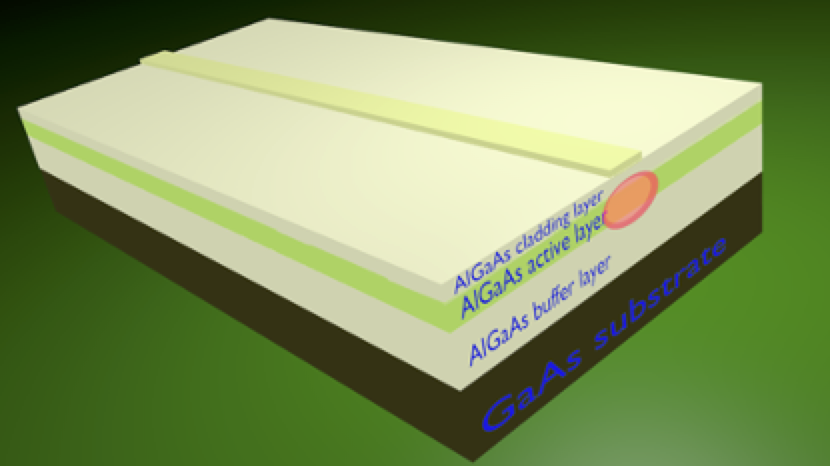

A schematic of the layout of AlGaAS waveguide showing layer structure The buffer layer is 4micron thick $Al_xGa_{1-x}As$ , x=0.25. The active core layer is 1.5 micron thick $Al_xGa_{1-x}As$ , x=0.18. The cladding layer layer is 1.5 micron thick $Al_xGa_{1-x}As$ , x=0.25.


Layer 1 Al fraction Clad1 Al=  0.25 ; Thickness (microns)  =  4.0 ; Refractive index, n= [3.25750857]  @ wavelength (microns) 1.55
Layer 2 Al fraction Core  Al=  0.18 ; Thickness (microns) =  1.5 ; Refractive index, n= [3.29003604]  @ wavelength (microns) 1.55
Layer 3 Al fraction Clad2 Al=  0.25 ; Thickness (microns) =  1.5 ; Refractive index, n= [3.25750857]  @ wavelength (microns) 1.55
          n_eff          
-------------------------
0 : 3.2770  +  -0.0000 i
1 : 3.2524  +  -0.0000 i
2 : 3.2419  +  -0.0000 i
3 : 3.2233  +  0.0000 i
4 : 3.2041  +  0.0000 i
5 : 3.1739  +  -0.0000 i
6 : 3.1412  +  -0.0000 i
7 : 3.1023  +  -0.0000 i


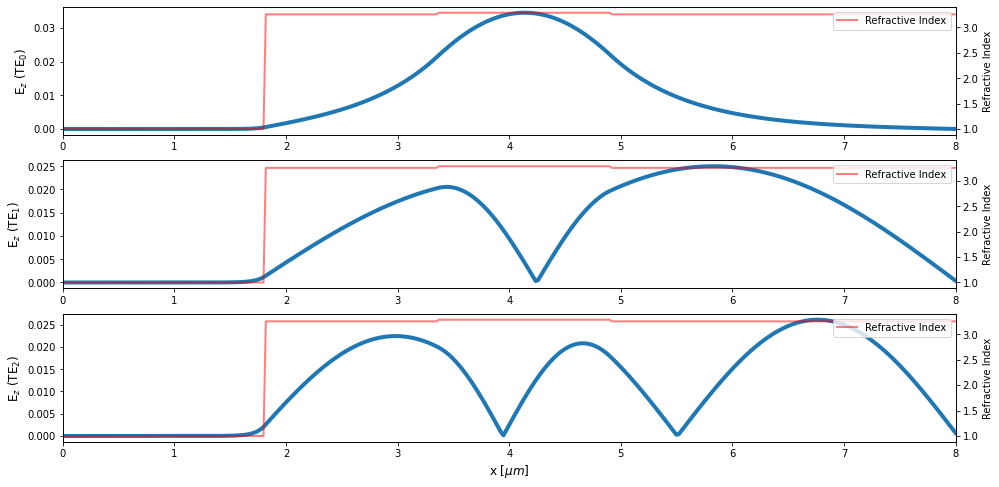

In [2]:
%matplotlib inline
"""This example is adapted from examples/simple_waveguide/simple_waveguide.py
"""
import emopt
from emopt.misc import NOT_PARALLEL

import numpy as np
H = 8.0 # choses region of interest in microns
dy = 0.02 # Cell size for FTDT
wavelength = 1.55 #wavelength in microns
clad1_Al_fraction=0.25 # Al fraction of cladding 1
core_Al_fraction=0.18 # Al fraction of core
clad2_Al_fraction=0.25 # Al fraction of cladding 2

"""Define the waveguide structure thickness and refractive index of materials"""
n_clad1=AlGaAs_interp(clad1_Al_fraction, wavelength, k=False)#refractive index of clad 1 AlxGa1-xAs x=0.25
n_core=AlGaAs_interp(core_Al_fraction, wavelength, k=False) #refractive index of core AlxGa1-xAs x=0.18
n_clad2=AlGaAs_interp(clad2_Al_fraction, wavelength, k=False) #refractive index of clad 2 AlxGa1-xAs x=0.25


Clad1_thickness=4.0#thickness clad1 in microns
Core_thickness=1.5 #thickness core in microns
Clad2_thickness=1.5#thickness clad2 in microns

print("Layer 1 Al fraction Clad1 Al= ", clad1_Al_fraction,"; Thickness (microns)  = ",Clad1_thickness, "; Refractive index, n=",n_clad1, " @ wavelength (microns)",wavelength)
print("Layer 2 Al fraction Core  Al= ", core_Al_fraction,"; Thickness (microns) = ",Core_thickness, "; Refractive index, n=",n_core, " @ wavelength (microns)",wavelength)
print("Layer 3 Al fraction Clad2 Al= ", clad2_Al_fraction,"; Thickness (microns) = ",Clad2_thickness, "; Refractive index, n=",n_clad2, " @ wavelength (microns)",wavelength)

off1=Core_thickness/2+Clad1_thickness/2#Centre of Clad1
off2=Core_thickness/2+Clad2_thickness/2#Centre of Clad2
span=5.0*wavelength

# Define rectangles for the waveguide structure and cladding
wg_clad1 = emopt.grid.Rectangle(0.0, (H/2+off1), span,Clad1_thickness)
wg_clad1.layer = 0; wg_clad1.material_value = n_clad1**2

wg_core = emopt.grid.Rectangle(0.0, H/2, span,Core_thickness)
wg_core.layer = 0; wg_core.material_value = n_core**2

wg_clad2 = emopt.grid.Rectangle(0.0, (H/2-off2),span,Clad2_thickness)
wg_clad2.layer = 0; wg_clad2.material_value = n_clad2**2


# Create a structured material which is just the ensemble of rectangles created above
# A slice from this StructuredMaterial will be used in the mode calculation
eps = emopt.grid.StructuredMaterial2D(1.0, H, dy, dy) # W and dx do not matter much
eps.add_primitive(wg_clad1);
eps.add_primitive(wg_core);
eps.add_primitive(wg_clad2);


mu = emopt.grid.ConstantMaterial2D(1.0)

#mode_line = emopt.misc.DomainCoordinates(0.5, 0.5, 0, H, 0.0, 0.0, 1.0, dy, 1.0)
mode_line = emopt.misc.DomainCoordinates(span/2, span/2, 0, span, 0, 0, dy, dy, dy)


neigs = 8
modes = emopt.modes.ModeTE(wavelength, eps, mu, mode_line, n0=n_core, neigs=neigs)
modes.build() # build the eigenvalue problem internally
modes.solve() # solve for the effective indices and mode profiles

if(NOT_PARALLEL):
    import matplotlib.pyplot as plt

    # print out the effective indices
    print('          n_eff          ')
    print('-------------------------')
    for j in range(neigs):
        n = modes.neff[j]
        print('%d : %0.4f  +  %0.4f i' % (j, n.real, n.imag))

    # plot the refractive index and mode profiles
    f, axes = plt.subplots(3,1,figsize=(16, 8))
    for j in range(3):
        i = modes.find_mode_index(j)
        Ez = modes.get_field_interp(i, 'Ez')
        x = np.linspace(0, H, mode_line.Ny)
        eps_arr = eps.get_values_in(mode_line, squeeze=True)

        ax = axes[j]
        ax.plot(x, np.abs(Ez), linewidth=4,label="Electric Field")
        ax.set_ylabel('E$_z$ (TE$_%d$)' % j, fontsize=12)
        ax.set_xlim([x[0], x[-1]])

        ax2 = ax.twinx()
        ax2.plot(x, np.sqrt(eps_arr.real), 'r-', linewidth=2, alpha=0.5,label="Refractive Index")
        ax2.set_ylabel('Refractive Index')
        plt.legend(loc=1)#writes legend on graph
    axes[2].set_xlabel('x [$\mu m$]', fontsize=12)
    plt.show()
